In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
img_paths = {i + 1: f'../imgs/{i + 1}.jpeg' for i in range(28)}

In [3]:
img_sample = cv2.imread(img_paths[1])

In [4]:
def show_img(img, cmap=None):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap=cmap)
    return

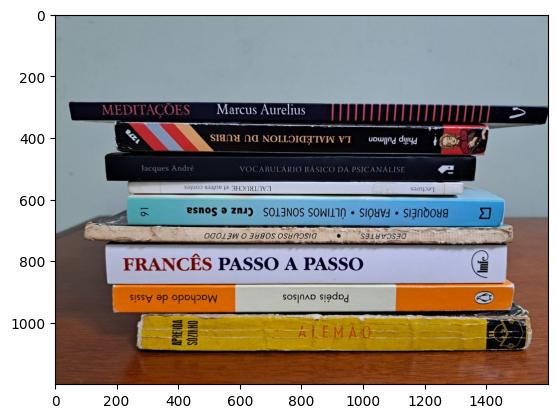

In [5]:
show_img(img_sample)

In [6]:
def convert_gray(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return gray_img

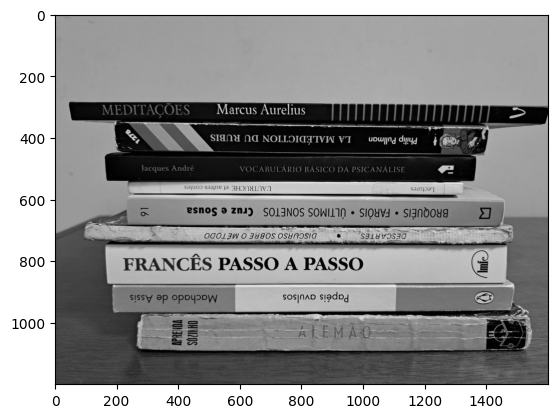

In [7]:
gray_img = convert_gray(img_sample)
plt.imshow(gray_img, cmap='grey')

In [8]:
gaussian_kernel_3 = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1],
])/16.

gaussian_kernel_5 = np.array([
    [1, 4, 7, 4, 1],
    [4, 16, 26, 16, 4],
    [7, 26, 41, 26, 7],
    [4, 16, 26, 16, 4],
    [1, 4, 7, 4, 1],
])/273.

sobel_kernel_gx_3 = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

sobel_kernel_gy_3 = np.transpose(sobel_kernel_gx_3)

sobel_kernel_gx_5 = np.array([
    [2, 2, 4, 2, 2],
    [1, 1, 2, 1, 1],
    [0, 0, 0, 0, 0],
    [-1, -1, -2, -1, -1],
    [-2, -2, -4, -2, -2]
])

sobel_kernel_gy_5 = np.transpose(sobel_kernel_gx_5)

In [9]:
def conv(img, kernel):
    return cv2.filter2D(src=img, ddepth=-1, kernel=kernel)

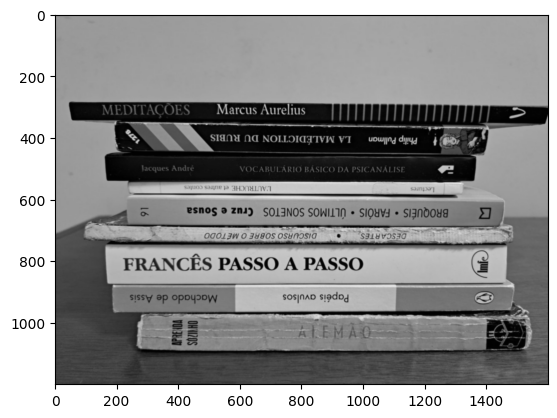

In [10]:
smooth_img = conv(gray_img, gaussian_kernel_5)
show_img(smooth_img)

Text(0.5, 1.0, 'Sobel kernel Gy 5x5 on smoothed image')

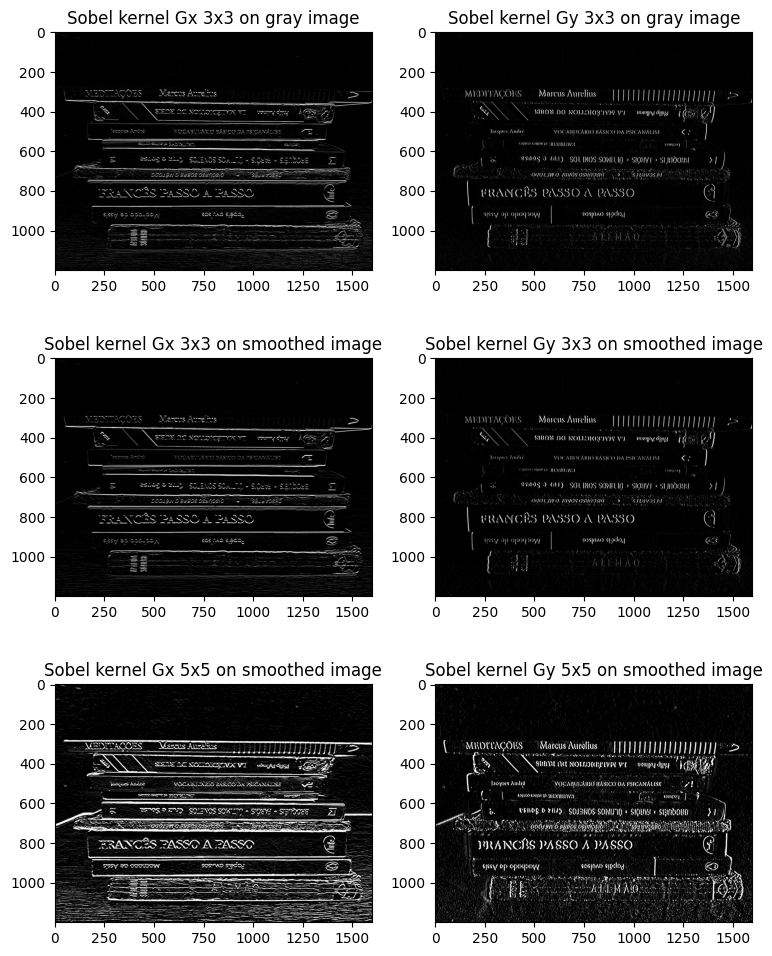

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(9, 12))

img_convy_3 = conv(smooth_img, sobel_kernel_gx_3)
img_convx_3 = conv(smooth_img, sobel_kernel_gy_3)
img_convy_5 = conv(gray_img, sobel_kernel_gx_5)
img_convx_5 = conv(gray_img, sobel_kernel_gy_5)

axs[0, 0].imshow(conv(gray_img, sobel_kernel_gx_3), cmap='gray')
axs[0, 1].imshow(conv(gray_img, sobel_kernel_gy_3), cmap='gray')
axs[1, 0].imshow(img_convy_3, cmap='gray')
axs[1, 1].imshow(img_convx_3, cmap='gray')
axs[2, 0].imshow(img_convy_5, cmap='gray')
axs[2, 1].imshow(img_convx_5, cmap='gray')

axs[0, 0].set_title('Sobel kernel Gx 3x3 on gray image')
axs[0, 1].set_title('Sobel kernel Gy 3x3 on gray image')
axs[1, 0].set_title('Sobel kernel Gx 3x3 on smoothed image')
axs[1, 1].set_title('Sobel kernel Gy 3x3 on smoothed image')
axs[2, 0].set_title('Sobel kernel Gx 5x5 on smoothed image')
axs[2, 1].set_title('Sobel kernel Gy 5x5 on smoothed image')

In [12]:
size_x, size_y = img_sample[:,:,0].shape[1], img_sample[:,:,0].shape[0]
size = size_x*size_y
freqx_matrix = np.ones((size_x, 1))
freqy_matrix = np.ones((1, size_y))

freqx_matrix, freqy_matrix

(array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], shape=(1600, 1)),
 array([[1., 1., 1., ..., 1., 1., 1.]], shape=(1, 1200)))

In [13]:
def count_axis(img, axis='x'):
    if axis == 'x':
        count_x = np.matmul(freqy_matrix, img)
        count_x = count_x/size
        count_x = count_x.reshape(size_x)
        return count_x
    else:
        count_y = np.matmul(img, freqx_matrix)
        count_y = count_y/size
        count_y = count_y.reshape(size_y)
        return count_y

count_axis(img_convy_3, axis='y')

array([0.        , 0.00072813, 0.00138646, ..., 0.00642917, 0.00434479,
       0.        ], shape=(1200,))

In [14]:
count_x = count_axis(img_convx_3, axis='x')
count_y = count_axis(img_convy_3, axis='y')

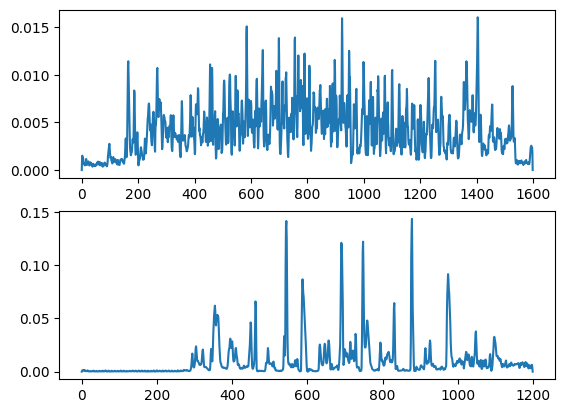

In [15]:
fig, axs = plt.subplots(2)

axs[0].plot(count_x)
axs[1].plot(count_y)

In [16]:
def get_diff(count):
    diff = np.diff(count)
    mean, max, min = np.mean(diff), np.max(diff), np.min(diff)
    amp = np.max([max, -min])
    diff = (diff - mean)/amp

    return diff

In [17]:
countx_diff = get_diff(count_x)
county_diff = get_diff(count_y)

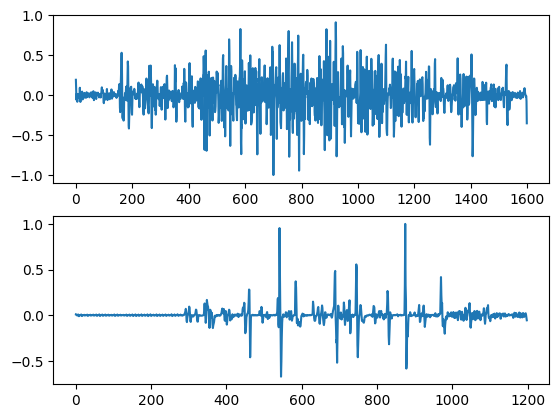

In [18]:
fig, axs = plt.subplots(2)

axs[0].plot(countx_diff)
axs[1].plot(county_diff)

In [19]:
np.var(countx_diff), np.var(county_diff)

(np.float64(0.043379879252434195), np.float64(0.007751390472437978))

In [20]:
def get_spikes(diff_series,alpha = 5.):
    Q1 = np.percentile(county_diff, alpha, method='midpoint')
    Q3 = np.percentile(county_diff, 100 - alpha, method='midpoint')
    IQR = Q3 - Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR

    new_series = diff_series > upper
    new_series = diff_series < lower
    
    return new_series

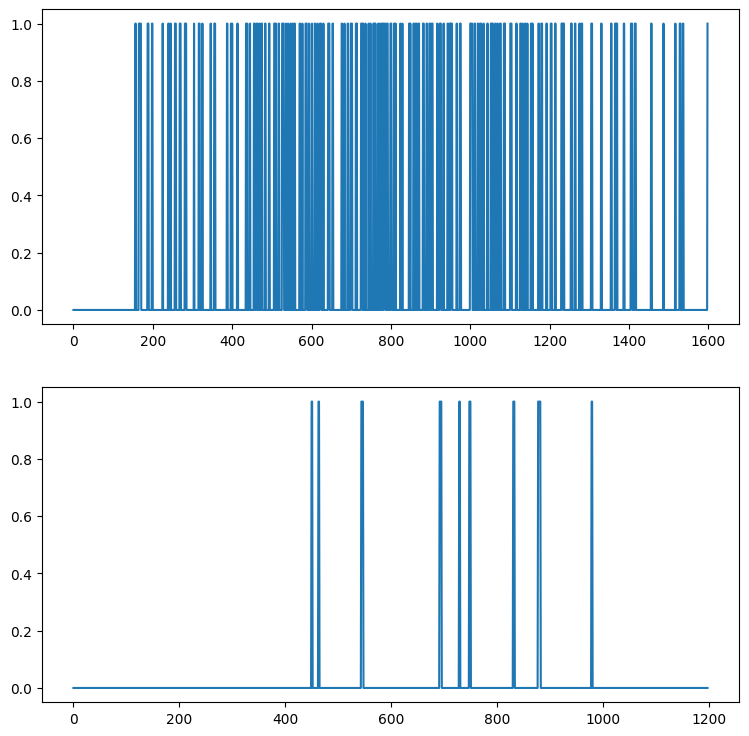

In [21]:
spikes_x = get_spikes(countx_diff, alpha=12)
spikes_y = get_spikes(county_diff, alpha=12)

fig, axs = plt.subplots(2, figsize=(9,9))

axs[0].plot(spikes_x)
axs[1].plot(spikes_y)

In [22]:
def get_slices_pos(spikes):
    positions = []
    n = len(spikes)

    on_spike = False
    spike_start = 0
    for i in range(n):
        if spikes[i] == True and on_spike == False:
            on_spike = True
            spike_start = i
            
        elif spikes[i] == False and on_spike == True:
            spike_end = i
            spike_pos = (spike_start + spike_end)//2
            positions.append(spike_pos)
            on_spike = False
    
    return positions

In [23]:
slices_posx = get_slices_pos(spikes_x)
slices_posy = get_slices_pos(spikes_y)

print(f'{slices_posx}\n{slices_posy}')

[157, 168, 188, 199, 225, 240, 245, 257, 269, 283, 304, 317, 325, 346, 356, 388, 397, 400, 414, 435, 438, 445, 456, 463, 469, 474, 484, 494, 507, 510, 518, 528, 536, 541, 548, 553, 558, 571, 577, 587, 594, 601, 609, 615, 623, 630, 644, 654, 677, 683, 692, 701, 712, 714, 727, 730, 736, 744, 749, 757, 759, 761, 769, 773, 778, 784, 791, 800, 809, 812, 824, 829, 847, 849, 858, 862, 865, 871, 882, 891, 898, 904, 917, 925, 933, 944, 949, 953, 966, 975, 1003, 1012, 1020, 1026, 1034, 1044, 1053, 1057, 1064, 1069, 1076, 1085, 1087, 1103, 1117, 1127, 1132, 1139, 1144, 1154, 1157, 1173, 1180, 1193, 1204, 1215, 1232, 1236, 1255, 1265, 1276, 1282, 1306, 1331, 1356, 1367, 1370, 1388, 1407, 1416, 1457, 1487, 1517, 1529, 1537]
[451, 464, 546, 694, 730, 749, 832, 880, 980]


In [24]:
def draw_contours(img, slices_pos, axis='x', color=(255, 0, 0), thickness=2):
    new_img = img.copy()
    w, h = img.shape[1], img.shape[0]
    
    if axis == 'x':
        print(f'x axis with w = {w} and h = {h}')
        for pos in slices_pos: line = cv2.line(new_img, (pos, 0), (pos, h), color, thickness)
    elif axis == 'y':
        print(f'y axis with w = {w} and h = {h}')
        for pos in slices_pos: line = cv2.line(new_img, (0, pos), (w, pos), color, thickness)

    return new_img

In [25]:
contours_x = draw_contours(img_sample, slices_posx, axis='x')
contours_y = draw_contours(img_sample, slices_posy, axis='y')

x axis with w = 1600 and h = 1200
y axis with w = 1600 and h = 1200


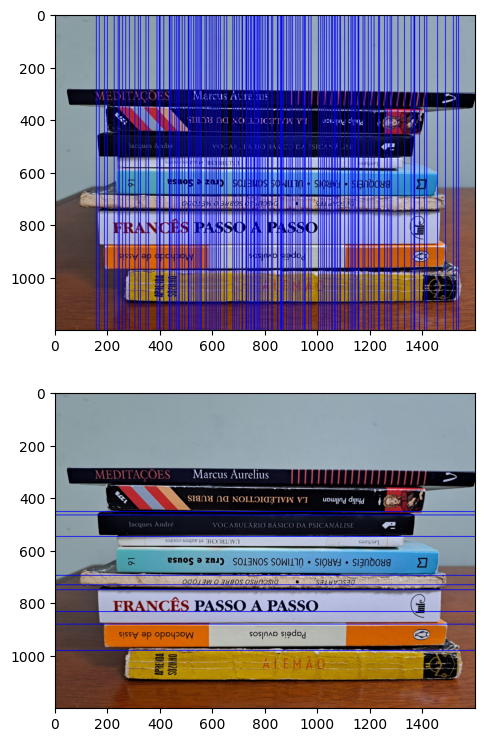

In [26]:
fig, axs = plt.subplots(2, figsize=(9, 9))

axs[0].imshow(cv2.cvtColor(contours_x, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(contours_y, cv2.COLOR_BGR2RGB))

In [27]:
def slice_img(img, slice_pos, axis='x'):
    slices = []
    w, h = img.shape[1], img.shape[0]

    if axis == 'x':
        last_x = 0
        slice_pos.append(w)
        for new_x in slice_pos:
            cropped_img = img[0:h, last_x:new_x]
            last_x = new_x
            slices.append(cropped_img)
        
    elif axis == 'y':
        last_y = 0
        slice_pos.append(h)
        for new_y in slice_pos:
            cropped_img = img[last_y:new_y, 0:w]
            last_y = new_y
            slices.append(cropped_img)
    
    return slices

In [28]:
vertical_slices = slice_img(img_sample, slices_posx, axis='x')
horizontal_slices = slice_img(img_sample, slices_posy, axis='y')

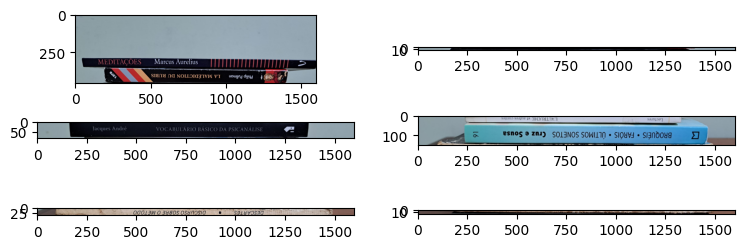

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(9, 3))

axs[0, 0].imshow(cv2.cvtColor(horizontal_slices[0], cv2.COLOR_BGR2RGB))
axs[0, 1].imshow(cv2.cvtColor(horizontal_slices[1], cv2.COLOR_BGR2RGB))
axs[1, 0].imshow(cv2.cvtColor(horizontal_slices[2], cv2.COLOR_BGR2RGB))
axs[1, 1].imshow(cv2.cvtColor(horizontal_slices[3], cv2.COLOR_BGR2RGB))
axs[2, 0].imshow(cv2.cvtColor(horizontal_slices[4], cv2.COLOR_BGR2RGB))
axs[2, 1].imshow(cv2.cvtColor(horizontal_slices[5], cv2.COLOR_BGR2RGB))

In [32]:
import pytesseract

In [35]:
def get_text(img_slices):
    texts = []
    for img_slice in img_slices:
        text = pytesseract.image_to_string(img_slice, config='--psm 6')
        texts.append(text)
    return texts

In [36]:
get_text(horizontal_slices)

['MEDITACOES Marcus Aurelius Wii =S=\n',
 '',
 'Jacques André VOCABULARIO BASICO DA PSICANALISE - aan\n',
 '— | sa]u09 saqNe 19 AHONALAW.A sauna]\nee\nae | a . esnog 9 2M4) SOLINOS SOWILIN © SIOUVI » siandoud ; 2 —\n',
 '_— Se: = eR ay, ee ee ee es oe eee eS ~~\n- - 5 = OdOLIW O FHGOS OSYNDSIG es “SILLY yOSsSIG ; . ™ ee\n',
 '— 0 Oo ee ee ee\n',
 'FRANCES PASSO A PASSO ea\n',
 '—\nSS NR a\n',
 '= | Sissy ep OPDYDDW Sos|NAD siadbq Ss | —\n',
 'as ee ae) Sel rs \\ \\ ae\na nag = Spa ES NEE bret Leer Ps WE Ve INS — -F —-\n; —\n']